In [32]:
from datetime import datetime as dt

base_dir = "./data/landcover_model"
start_date = dt(2022, 1, 1)
end_date = dt(2022, 3, 1)
bbox_sb = [-119.709622, 34.395196, -119.596430, 34.451896]

cloud_mask_model_path = "./cloud_detection_model_resnet18_dice_20230327.pth"

bbox = bbox_sb # change to bbox as necessary

In [5]:
from common.utilities.download import get_collection, get_processed_composite

collection_path = f'{base_dir}/collection.json'
collection = get_collection(start_date, end_date, bbox, collection_path, max_cloud_cover=20, max_tile_count=4, min_tile_count=3)
composite_path = get_processed_composite(collection, bbox, base_dir, cloud_mask_model_path)


./data/landcover_model/collection.json: {'GD': 4, 'KU': 4}
	downloading... S2A_10SGD_20220210_0_L2A
	downloading... S2A_11SKU_20220210_0_L2A
	downloading... S2B_10SGD_20220126_0_L2A
	downloading... S2A_10SGD_20220111_0_L2A
	downloading... S2B_11SKU_20220126_0_L2A
	downloading... S2B_10SGD_20220225_0_L2A
	downloading... S2B_11SKU_20220106_0_L2A
	downloading... S2A_11SKU_20220111_0_L2A
	masking... S2A_10SGD_20220210_0_L2A


/var/lang/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


	masking... S2A_11SKU_20220210_0_L2A
	masking... S2B_10SGD_20220126_0_L2A
	masking... S2A_10SGD_20220111_0_L2A
	masking... S2B_11SKU_20220126_0_L2A
	masking... S2B_10SGD_20220225_0_L2A
	masking... S2B_11SKU_20220106_0_L2A
	masking... S2A_11SKU_20220111_0_L2A


In [8]:

model_path = "./landcover_classification_model_resnet18_dice_20230328.pth"


In [30]:
import numpy as np
import rasterio
import torch


with rasterio.open(composite_path) as src:
    og_image = src.read()
    saved_shape = og_image.shape

height_pad = 32 - (og_image.shape[1] % 32)
width_pad = 32 - (og_image.shape[2] % 32)
padded_image = np.pad(og_image, ((0, 0), (0, height_pad), (0, width_pad)), mode='reflect')

image = np.expand_dims(padded_image, 0)     
image = torch.tensor(image)

model = torch.load(model_path)

prediction = model.predict(image)

probabilities = torch.sigmoid(prediction)
prediction = torch.argmax(probabilities, dim=1)

prediction = (prediction.squeeze().cpu().numpy().round())
prediction = np.ma.array(prediction, mask=(prediction==0))

og_image = og_image[:, :saved_shape[1], :saved_shape[2]]
prediction = prediction[:saved_shape[1], :saved_shape[2]]


print('done')

done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Prediction')

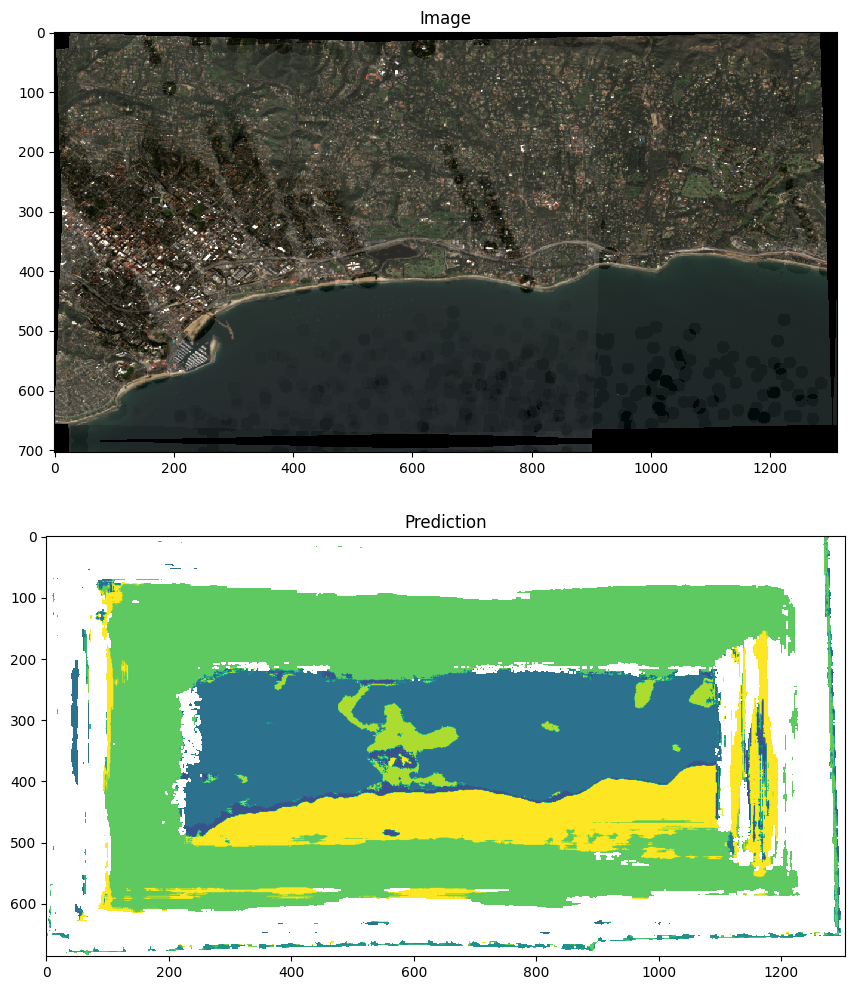

In [31]:
import matplotlib.pyplot as plt

from common.utilities.visualization import plot_bands


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

plot_bands(padded_image, bands=[2, 1, 0], ax=ax1, transpose=True)
ax1.set_title('Image')

ax2.imshow(prediction, vmin=0, vmax=8)
ax2.set_title('Prediction')

In [36]:
from common.utilities.imagery import write_array_to_tif

colors = {
    0: (0, 0, 0),       # Class 0: Black
    1: (255, 200, 200), # Class 1: White
    2: (50, 255, 0),     # Class 2: Green
    3: (255, 255, 0),   # Class 3: Yellow
    4: (0, 50, 255),     # Class 4: Blue
    5: (255, 50, 255),   # Class 5: Magenta
    6: (255, 99, 23),     # Class 6: Red
}

colored_landcover = np.zeros((prediction.shape[0], prediction.shape[1], 3), dtype=np.uint8)
for value, color in colors.items():
    mask = prediction == value
    colored_landcover[mask] = color
    
print(colored_landcover)
    
prediction_color_path = f'{base_dir}/prediction_color.tif'
write_array_to_tif(prediction, prediction_color_path, bbox_sb, dtype=np.uint8, epsg=4326, nodata=255)

[[[  0   0   0]
  [255  99  23]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[255  99  23]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
